# Create Inference Endpoint on Huggingface for Llava-Next (Llava-v1.6)

Note: you might need to update `huggingface_hub` to the latest version with `pip install -U huggingface_hubg` to run this notebook.

Then, login to your Huggingface account with:
```bash
!huggingface-cli login
```

In [ ]:
from huggingface_hub import create_inference_endpoint

## Create Inference Endpoint on Huggingface

Note that this costs $4 per hour.

In [83]:
# repository = "HuggingFaceM4/idefics2-8b"
# endpoint_name = "idefics2-8b-00"
repository = "llava-hf/llava-v1.6-vicuna-13b-hf"
endpoint_name = "llava-v1-6-vicuna-13b-hf-j3a"
namespace = "leloy"

In [ ]:
endpoint = create_inference_endpoint(
    endpoint_name,
    repository=repository,
    # namespace=namespace,
    framework="pytorch",
    task="text-generation",
    accelerator="gpu",
    vendor="aws",
    region="us-east-1",
    type="protected",
    instance_size="x4",  #"medium", 
    instance_type="nvidia-a100",  #"g5.2xlarge",
    min_replica=0,
    max_replica=1,
    custom_image={
        "health_route": "/health",
        "env": {
            "MAX_BATCH_PREFILL_TOKENS": "4096",
            "MAX_INPUT_LENGTH": "3072",
            "MAX_TOTAL_TOKENS": "8192",
            "MODEL_ID": "/repository"
        },
        # If you receive an error, try upgrading or downgrading the TGI image
        "url": "ghcr.io/huggingface/text-generation-inference:2.0.2",
    },
)

endpoint.wait()
print(endpoint.status)

## Test

In [15]:
import requests
import base64
from io import BytesIO

import huggingface_hub
from transformers import LlavaNextProcessor
from transformers.image_processing_utils import select_best_resolution
from PIL import Image, ImageOps
from PIL.Image import Image as PILImage

In [2]:
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-13b-hf")

In [3]:
def resize_and_pad_image(image: PILImage) -> PILImage:
    possible_resolutions = processor.image_processor.image_grid_pinpoints
    best_resolution = select_best_resolution(image.size, possible_resolutions)
    resized_image = ImageOps.cover(image, best_resolution)
    resized_and_padded_image = ImageOps.pad(
        resized_image,
        best_resolution,
        method=processor.image_processor.resample,
    )
    return resized_and_padded_image

In [8]:
def encode_local_image(image_path, resize_and_pad: bool = True):
    # load image
    image = Image.open(image_path)
    if resize_and_pad:
        image = resize_and_pad_image(image)
        print(f"New size: {image.size}")

    # Convert the image to a base64 string
    buffer = BytesIO()
    image.save(buffer, format="PNG")  # Use the appropriate format (e.g., JPEG, PNG)
    base64_image = base64.b64encode(buffer.getvalue()).decode('utf-8')

    # add string formatting required by the endpoint
    image_string = f"data:image/png;base64,{base64_image}"

    return image_string

In [9]:
prompt_format = "<system_prompt> USER: <image>\\n<user> ASSISTANT: "

In [10]:
# SYSTEM_PROMPT = "You are an infographics explainer. You will receive an image as an input and you must answer the user's question based on the image. Be concise and limit responses to at most 3 sentences, preferably one sentence long. Respond in English."
SYSTEM_PROMPT = """"You are a document information extractor. You get an image as an input and you must answer the user's question from the data you extract from the image. Output in the following json format: {"answer_reasoning": {"type": "string"}, "concise_answer": {"type": "string"}}"""

In [11]:
# image_path = "data/raw_datasets/myinfographic/images/4-things-you-shouldnt-on-your-workers-compensation-form_550ff272f368e_w1500.jpg"
image_path = "data/raw_datasets/mydoc/images/fe0111cf63f253246d3b0e1919d3b44e189e0355b77234a5c72bf62e4c5fb7e6.png"

In [12]:
# question = "What is the infographic about?"
question = "What is the average unit rate in the document?"

New size: (672, 672)


'"You are a document information extractor. You get an image as an input and you must answer the user\'s question from the data you extract from the image. Output in the following json format: {"answer_reasoning": {"type": "string"}, "concise_answer": {"type": "string"}} USER: \\nWhat is the average unit rate in the document? ASSISTANT: '
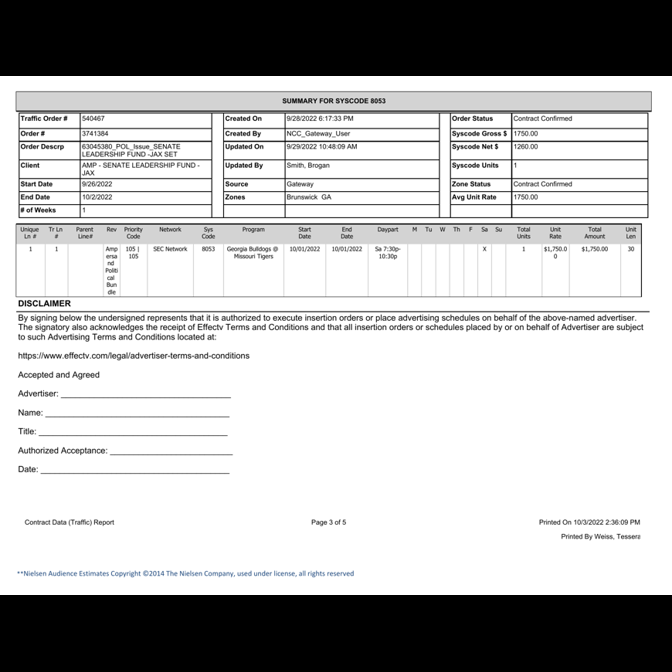

In [20]:
prompt = (
    prompt_format
    .replace("<system_prompt>", SYSTEM_PROMPT)
    .replace("<image>", f"![]({encode_local_image(image_path)})")
    .replace("<user>", question)
)
prompt

In [25]:
API_URL = "https://bkliyhzstf7g5dyz.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {huggingface_hub.get_token()}",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()


# This version of TGI uses an older version of Outlines
# which re-orders the keys in the JSON in alphabetical order.
# Hence the prefixes in the keys in the grammer
output = query({
	"inputs": prompt,
	"parameters": {
		"return_full_text": False,
		"max_new_tokens": 2048,
		"frequency_penalty": 1,
        "temperature": 1,
        "top_p": 0.95,
        "frequency_penalty": 0,
        "presence_penalty": 0,
		"grammar": {
            "type": "json",
            "value": {
                "properties": {
                    "answer_reasoning": {"type": "string"},
                    "concise_answer": {
						"type": "string",
						"description": "Concise answer to the user question, exactly as it appears in the document.",
					},
                },
                "required": ["answer_reasoning", "concise_answer"]
            }
        }
	}
})

In [26]:
output

[{'generated_text': '{"answer_reasoning": "To find the average unit rate for this insertion order, I would need to add up all the orders and divide by the number of units.",\n "concise_answer": "1750.00"}'}]

In [ ]:
API_URL = "https://bkliyhzstf7g5dyz.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {huggingface_hub.get_token()}",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()


# This version of TGI uses an older version of Outlines
# which re-orders the keys in the JSON in alphabetical order.
# Hence the prefixes in the keys in the grammer
output = query({
	"messages": [
		{
			"role": "system",
			"content": SYSTEM_PROMPT,
        },
		{
			"role": "user",
			"content": [
				{
					"type": "text",
					"content": question,
				},
				
				{
					"type": "image",
					"image_url": {
						"url": encode_local_image(image_path),
                    }
                },
			],
		}
	],
	"parameters": {
		"return_full_text": False,
		"max_new_tokens": 2048,
		"frequency_penalty": 1,
        "temperature": 1,
        "top_p": 0.95,
        "frequency_penalty": 0,
        "presence_penalty": 0,
		"grammar": {
            "type": "json",
            "value": {
                "properties": {
                    "answer_reasoning": {"type": "string"},
                    "concise_answer": {"type": "string"},
                },
                "required": ["answer_reasoning", "concise_answer"]
            }
        }
	}
})